In [1]:
import pandas as pd
import numpy as np

In [6]:
# Загрузка данных
names = ['user_id', 'item_id', 'rating', 'timestamp']

ratings = pd.read_csv("ratings.csv", sep=',',header=0, names=names)

# Проверка структуры данных
print(ratings.head())

   user_id  item_id  rating  timestamp
0        1        1     4.0  964982703
1        1        3     4.0  964981247
2        1        6     4.0  964982224
3        1       47     5.0  964983815
4        1       50     5.0  964982931


In [8]:
# Выделение уникальных пользователей
user_ids = ratings['user_id'].unique()

# Случайным образом выбираем 40% пользователей
np.random.seed(42)  # Задаем seed для воспроизводимости
hidden_users = np.random.choice(user_ids, size=int(0.4 * len(user_ids)), replace=False)

# Разделяем данные: оценки выбранных пользователей
hidden_ratings = ratings[ratings['user_id'].isin(hidden_users)]

# Скроем 40% оценок для каждого из выбранных пользователей
def hide_ratings(user_data):
    sample_size = int(len(user_data) * 0.4)
    hidden_indices = user_data.sample(n=sample_size, random_state=42).index
    return hidden_indices

hidden_indices = hidden_ratings.groupby('user_id').apply(hide_ratings).explode()
Final_test_set = ratings.loc[hidden_indices]

# Оставшиеся данные
remaining_data = ratings.drop(index=hidden_indices)

# Выводим размеры наборов данных
print(f"Total ratings: {len(ratings)}")
print(f"Final_test_set (hidden data): {len(Final_test_set)}")
print(f"Remaining data: {len(remaining_data)}")

Total ratings: 100836
Final_test_set (hidden data): 18033
Remaining data: 82803


/var/folders/zf/941j075n5gd1qy64f_2xs0bw0000gq/T/ipykernel_95490/1677739986.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hidden_indices = hidden_ratings.groupby('user_id').apply(hide_ratings).explode()


In [9]:
# Перемешиваем оставшиеся данные
remaining_data = remaining_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Определяем размер Train/Validation
train_size = int(0.85 * len(remaining_data))

# Разделяем данные
Train_set = remaining_data[:train_size]
Validation_set = remaining_data[train_size:]

# Выводим размеры частей
print(f"Train_set size: {len(Train_set)}")
print(f"Validation_set size: {len(Validation_set)}")

Train_set size: 70382
Validation_set size: 12421


### Имплементация: ALS для SVD

In [19]:
from numpy.linalg import solve
from sklearn.metrics import mean_squared_error

class ALS_SVD:
    def __init__(self, ratings, n_factors=40, regularization=0.1, verbose=False):
        """
        ALS for Matrix Factorization
        :param ratings: User x Item matrix
        :param n_factors: Number of latent factors
        :param regularization: Regularization parameter (lambda)
        :param verbose: Enable debug information
        """
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.regularization = regularization
        self.verbose = verbose
        # Initialize latent factor matrices
        self.user_factors = np.random.normal(scale=1.0/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=1.0/self.n_factors, size=(self.n_items, self.n_factors))

    def train(self, n_iter=10):
        """Train the model for a given number of iterations."""
        for iteration in range(n_iter):
            if self.verbose:
                print(f"Iteration {iteration + 1} of {n_iter}")
            # Update user and item factors alternately
            self.user_factors = self.als_update(self.user_factors, self.item_factors, self.ratings, self.regularization, type="user")
            self.item_factors = self.als_update(self.item_factors, self.user_factors, self.ratings.T, self.regularization, type="item")
            
    def als_update(self, latent_vectors, fixed_vectors, ratings, regularization, type="user"):
        """
        ALS optimization step.
        Updates `latent_vectors` (user or item) while keeping `fixed_vectors` constant.
        """
        YTY = fixed_vectors.T @ fixed_vectors
        lambda_I = np.eye(YTY.shape[0]) * regularization
        for i in range(latent_vectors.shape[0]):
            numerator = ratings[i, :] @ fixed_vectors
            latent_vectors[i, :] = solve(YTY + lambda_I, numerator)
        return latent_vectors
    
    def predict(self):
        """
        Predict the full User x Item matrix.
        """
        return self.user_factors @ self.item_factors.T
    
    def calculate_rmse(self, test_data):
        """
        Compute RMSE for the given test data.
        """
        pred = self.predict()
        pred = pred[test_data.nonzero()].flatten()
        actual = test_data[test_data.nonzero()].flatten()
        
        # Проверим наличие NaN перед расчетом
        if np.isnan(pred).any() or np.isnan(actual).any():
            raise ValueError("Prediction or test data contains NaN!")
        
        return np.sqrt(mean_squared_error(pred, actual))

### Имплементация: SGD для SVD

In [20]:
class SGD_SVD:
    def __init__(self, ratings, n_factors=40, learning_rate=0.01, regularization=0.1, verbose=False):
        """
        SGD for Matrix Factorization
        :param ratings: User x Item matrix
        :param n_factors: Number of latent factors
        :param learning_rate: Gradient descent step size
        :param regularization: Regularization parameter (lambda)
        :param verbose: Enable debug information
        """
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.verbose = verbose
        # Initialize latent factor matrices
        self.user_factors = np.random.normal(scale=1.0/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=1.0/self.n_factors, size=(self.n_items, self.n_factors))

    def train(self, n_iter=10):
        """Train the model using SGD."""
        for iteration in range(n_iter):
            if self.verbose:
                print(f"Iteration {iteration + 1} of {n_iter}")
            # Stochastic Gradient Descent
            for u, i in zip(*self.ratings.nonzero()):
                e_ui = self.ratings[u, i] - self.user_factors[u, :] @ self.item_factors[i, :].T
                # Update user and item latent factors
                self.user_factors[u, :] += self.learning_rate * (e_ui * self.item_factors[i, :] - self.regularization * self.user_factors[u, :])
                self.item_factors[i, :] += self.learning_rate * (e_ui * self.user_factors[u, :] - self.regularization * self.item_factors[i, :])
    
    def predict(self):
        """
        Predict the full User x Item matrix.
        """
        return self.user_factors @ self.item_factors.T
    
    def calculate_rmse(self, test_data):
        """
        Compute RMSE for the given test data.
        """
        pred = self.predict()
        pred = pred[test_data.nonzero()].flatten()
        actual = test_data[test_data.nonzero()].flatten()
    
        # Проверим наличие NaN перед расчетом
        if np.isnan(pred).any() or np.isnan(actual).any():
            raise ValueError("Prediction or test data contains NaN!")
    
        return np.sqrt(mean_squared_error(pred, actual))

## Задача 6: Сравнение реализаций

In [13]:
# Преобразуем данные Train_set и Validation_set в формат User x Item
train_matrix = Train_set.pivot(index='user_id', columns='item_id', values='rating').fillna(0).to_numpy()
validation_matrix = Validation_set.pivot(index='user_id', columns='item_id', values='rating').fillna(0).to_numpy()

# Проверим размеры
print(f"Train matrix shape: {train_matrix.shape}")
print(f"Validation matrix shape: {validation_matrix.shape}")

Train matrix shape: (610, 8419)
Validation matrix shape: (604, 3963)


In [14]:
# ALS implementation
als_model = ALS_SVD(train_matrix, n_factors=40, regularization=0.1, verbose=True)
%time als_model.train(n_iter=10)
als_rmse = als_model.calculate_rmse(validation_matrix)
print(f"ALS RMSE on Validation Set: {als_rmse}")

# SGD implementation
sgd_model = SGD_SVD(train_matrix, n_factors=40, learning_rate=0.01, regularization=0.1, verbose=True)
%time sgd_model.train(n_iter=10)
sgd_rmse = sgd_model.calculate_rmse(validation_matrix)
print(f"SGD RMSE on Validation Set: {sgd_rmse}")

Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10
CPU times: user 1.99 s, sys: 76.1 ms, total: 2.06 s
Wall time: 2.05 s
ALS RMSE on Validation Set: 3.577567839973682
Iteration 1 of 10
Iteration 2 of 10
Iteration 3 of 10
Iteration 4 of 10
Iteration 5 of 10
Iteration 6 of 10
Iteration 7 of 10
Iteration 8 of 10
Iteration 9 of 10
Iteration 10 of 10
CPU times: user 4.5 s, sys: 33.9 ms, total: 4.54 s
Wall time: 4.54 s
SGD RMSE on Validation Set: 1.6877828722576618


### Визуализация результатов

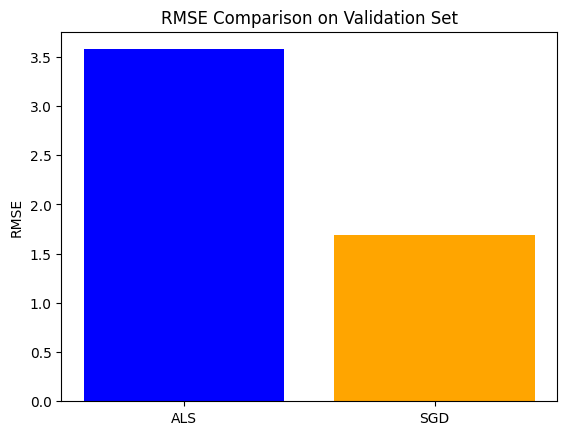

In [16]:
import matplotlib.pyplot as plt
methods = ['ALS', 'SGD']
rmse_scores = [als_rmse, sgd_rmse]

plt.bar(methods, rmse_scores, color=['blue', 'orange'])
plt.title('RMSE Comparison on Validation Set')
plt.ylabel('RMSE')
plt.show()

## Задача 7: Подбор лучших параметров

In [17]:
# Функция для тестирования разных параметров модели ALS
def tune_als(ratings, validation, factors_list, regularization_list, n_iter=10):
    best_params = {}
    best_rmse = float("inf")
    print("Tuning ALS...")
    for n_factors in factors_list:
        for reg in regularization_list:
            als_model = ALS_SVD(ratings, n_factors=n_factors, regularization=reg, verbose=False)
            als_model.train(n_iter=n_iter)
            rmse = als_model.calculate_rmse(validation)
            print(f"ALS | Factors: {n_factors}, Regularization: {reg}, RMSE: {rmse}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {"method": "ALS", "factors": n_factors, "regularization": reg}
    print(f"Best ALS RMSE: {best_rmse} with {best_params}")
    return best_params, best_rmse

# Функция для тестирования разных параметров модели SGD
def tune_sgd(ratings, validation, factors_list, lr_list, reg_list, n_iter=10, decay=False):
    best_params = {}
    best_rmse = float("inf")
    print("Tuning SGD...")
    for n_factors in factors_list:
        for lr in lr_list:
            for reg in reg_list:
                sgd_model = SGD_SVD(ratings, n_factors=n_factors, learning_rate=lr, regularization=reg, verbose=False)
                # Добавляем стратегию изменения learning rate
                if decay:
                    for i in range(1, n_iter + 1):
                        adjusted_lr = lr / i  # Уменьшаем learning rate с каждой итерацией
                        sgd_model.train(n_iter=1)
                        sgd_model.learning_rate = adjusted_lr
                else:
                    sgd_model.train(n_iter=n_iter)
                rmse = sgd_model.calculate_rmse(validation)
                print(f"SGD | Factors: {n_factors}, LR: {lr}, Regularization: {reg}, RMSE: {rmse}")
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {"method": "SGD", "factors": n_factors, "learning_rate": lr, "regularization": reg}
    print(f"Best SGD RMSE: {best_rmse} with {best_params}")
    return best_params, best_rmse

In [22]:
# Подготовка данных для обучения
train_matrix = Train_set.pivot(index='user_id', columns='item_id', values='rating').fillna(0).to_numpy()
validation_matrix = Validation_set.pivot(index='user_id', columns='item_id', values='rating').fillna(0).to_numpy()

# Гиперпараметры
factors_list = [10, 20, 40, 60, 80]
regularization_list = [0.01, 0.1, 0.5, 1.0]
lr_list = [0.001, 0.005, 0.01]

# ALS tuning
best_als_params, best_als_rmse = tune_als(train_matrix, validation_matrix, factors_list, regularization_list, n_iter=20)

# SGD tuning (без изменения скорости обучения)
best_sgd_params_fixed, best_sgd_rmse_fixed = tune_sgd(train_matrix, validation_matrix, factors_list, lr_list, regularization_list, n_iter=20, decay=False)

# SGD tuning (с убывающим шагом обучения)
best_sgd_params_decay, best_sgd_rmse_decay = tune_sgd(train_matrix, validation_matrix, factors_list, lr_list, regularization_list, n_iter=20, decay=True)

# Вывод лучших результатов
print(f"Best ALS RMSE: {best_als_rmse}, Params: {best_als_params}")
print(f"Best SGD RMSE (fixed LR): {best_sgd_rmse_fixed}, Params: {best_sgd_params_fixed}")
print(f"Best SGD RMSE (decay LR): {best_sgd_rmse_decay}, Params: {best_sgd_params_decay}")

Tuning ALS...
ALS | Factors: 10, Regularization: 0.01, RMSE: 3.5726595610980114
ALS | Factors: 10, Regularization: 0.1, RMSE: 3.573279703201949
ALS | Factors: 10, Regularization: 0.5, RMSE: 3.573545127749696
ALS | Factors: 10, Regularization: 1.0, RMSE: 3.573821790979787
ALS | Factors: 20, Regularization: 0.01, RMSE: 3.574535721737694
ALS | Factors: 20, Regularization: 0.1, RMSE: 3.5742074648402933
ALS | Factors: 20, Regularization: 0.5, RMSE: 3.574974904738644
ALS | Factors: 20, Regularization: 1.0, RMSE: 3.575549450070836
ALS | Factors: 40, Regularization: 0.01, RMSE: 3.5769835679770132
ALS | Factors: 40, Regularization: 0.1, RMSE: 3.5776125310025972
ALS | Factors: 40, Regularization: 0.5, RMSE: 3.57716926379817
ALS | Factors: 40, Regularization: 1.0, RMSE: 3.5771304344842085
ALS | Factors: 60, Regularization: 0.01, RMSE: 3.5811191774102746
ALS | Factors: 60, Regularization: 0.1, RMSE: 3.5810271619261207
ALS | Factors: 60, Regularization: 0.5, RMSE: 3.5810887862545204
ALS | Factors: 

## Задача 8: Выбор лучшей модели для SVD

In [23]:
if best_als_rmse < best_sgd_rmse_fixed and best_als_rmse < best_sgd_rmse_decay:
    best_model = "ALS"
    best_model_params = best_als_params
    final_rmse = best_als_rmse
elif best_sgd_rmse_fixed < best_sgd_rmse_decay:
    best_model = "SGD (Fixed LR)"
    best_model_params = best_sgd_params_fixed
    final_rmse = best_sgd_rmse_fixed
else:
    best_model = "SGD (Decay LR)"
    best_model_params = best_sgd_params_decay
    final_rmse = best_sgd_rmse_decay

print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_model_params}")
print(f"Best Validation RMSE: {final_rmse}")

Best Model: SGD (Fixed LR)
Best Parameters: {'method': 'SGD', 'factors': 80, 'learning_rate': 0.01, 'regularization': 0.01}
Best Validation RMSE: 1.431085492919433


## Задача 9: Реализация модели рекомендации на основе похожести фильмов

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
import numpy as np
import pandas as pd

# Построим модель рекомендации на основе схожести фильмов
class ItemSimilarityModel:
    def __init__(self, train_data):
        """
        Инициализация модели и расчет матрицы схожести между фильмами.
        """
        self.train_data = train_data
        self.similarity_matrix = self.calculate_similarity()  # Фильмы x Фильмы

    def calculate_similarity(self):
        """
        Рассчитываем матрицу косинусной схожести между фильмами на основе их профилей оценок.
        """
        # Создаем матрицу User x Item из Train_set
        user_item_matrix = self.train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0).T  # Items x Users
        # Рассчитываем косинусное сходство между фильмами (строки — фильмы)
        similarity_matrix = cosine_similarity(user_item_matrix)
        return pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

    def predict(self):
        """
        Предсказываем рейтинги для всех пользователей и фильмов, возвращаем User x Item матрицу.
        """
        # Создаем User x Item матрицу из тренировочных данных
        user_item_matrix = self.train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

        # Матрица для хранения предсказаний (указываем float для предотвращения ошибок типов)
        predictions = pd.DataFrame(0.0, index=user_item_matrix.index, columns=user_item_matrix.columns)

        # Заполняем предсказания
        for item_id in user_item_matrix.columns:
            # Получаем схожесть данного фильма с другими
            similar_items = self.similarity_matrix[item_id]

            for user_id in user_item_matrix.index:
                rated_items = user_item_matrix.loc[user_id]  # Оценки пользователя
                rated_items = rated_items[rated_items > 0]  # Оставляем только фильмы с ненулевыми оценками
                
                if len(rated_items) > 0:
                    denominator = np.sum(np.abs(similar_items[rated_items.index]))
                    if denominator > 0:
                        # Рассчитываем предсказание, если знаменатель больше нуля
                        prediction = np.sum(similar_items[rated_items.index] * rated_items) / denominator
                    else:
                        # Если знаменатель равен 0, устанавливаем предсказание в 0
                        prediction = 0
                    # Сохраняем предсказание
                    predictions.at[user_id, item_id] = prediction

        return predictions.to_numpy()

## Задача 10: Сравнение модели SVD и модели на основе похожести фильмов по NDCG на Validation_set

In [47]:
def calculate_ndcg_1(model, validation_data, k=10):
    """
    Рассчитать среднее NDCG для модели на `Validation_set`.
    
    :param model: обученная модель (метод `predict` должен возвращать полную матрицу предсказаний)
    :param validation_data: `Validation_set` в формате DataFrame
    :param k: количество позиций для NDCG
    :return: средний NDCG для всех пользователей
    """
    ndcg_scores = []

    # Преобразуем Validation_set в матрицу user × item
    val_matrix_df = validation_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

    # Предсказания для всех пользователей
    pred_matrix = model.predict()  # Матрица предсказанных рейтингов (модель возвращает полную матрицу)
    
    # Преобразуем pred_matrix в DataFrame с той же индексной структурой
    pred_matrix_df = pd.DataFrame(pred_matrix)

    # Приведение формата pred_matrix к формату val_matrix (то есть согласуем ID пользователей и фильмов)
    pred_matrix_df = pred_matrix_df.reindex(index=val_matrix_df.index, columns=val_matrix_df.columns, fill_value=0)

    # Приводим валидационную матрицу (на случай, если у модели больше данных)
    val_matrix_df = val_matrix_df.reindex(index=pred_matrix_df.index, columns=pred_matrix_df.columns, fill_value=0)

    # Преобразуем обратно в массивы для NDCG
    val_matrix = val_matrix_df.to_numpy()
    pred_matrix = pred_matrix_df.to_numpy()

    # Рассчитываем NDCG для каждого пользователя
    for user_index in range(val_matrix.shape[0]):
        # Истинные рейтинги пользователя из Validation_set
        true_ratings = val_matrix[user_index].reshape(1, -1)
        
        # Предсказанные рейтинги пользователя
        predicted_ratings = pred_matrix[user_index].reshape(1, -1)
        
        # Пропускаем пользователей без рейтингов (только нули в валидационной выборке)
        if np.sum(true_ratings) == 0:
            continue

        # Считаем NDCG для пользователя
        ndcg_scores.append(ndcg_score(true_ratings, predicted_ratings, k=k))

    if len(ndcg_scores) == 0:  # Если нет ни одного рейтинга
        print("No users with valid ratings for NDCG calculation.")
        return None

    # Вернём среднее NDCG
    return np.mean(ndcg_scores)

In [48]:
from sklearn.metrics import ndcg_score

def calculate_ndcg_2(model, validation_data, k=10):
    """
    Рассчитать средний NDCG для модели на Validation_set.
    
    :param model: обученная модель (метод `predict` возвращает всю матрицу предсказаний).
    :param validation_data: Validation_set в формате DataFrame (user_id, item_id, rating).
    :param k: количество позиций для NDCG
    :return: Средний NDCG между предсказаниями и валидацией
    """
    # Преобразуем Validation_set в матрицу User x Item
    val_matrix_df = validation_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

    # Прогнозы модели (матрица предсказаний)
    pred_matrix = model.predict()  # Получаем NumPy массив (User x Item), всегда имеет размеры train_set
    
    # Преобразуем pred_matrix в DataFrame, чтобы согласовать индексы и столбцы (на случай несовпадения размеров)
    pred_matrix_df = pd.DataFrame(pred_matrix, index=model.train_data['user_id'].unique(),
                                   columns=model.train_data['item_id'].unique())

    # Согласовываем размеры, если индексы или столбцы в матрицах не совпадают
    all_users = val_matrix_df.index.union(pred_matrix_df.index)  # Все пользователи
    all_items = val_matrix_df.columns.union(pred_matrix_df.columns)  # Все фильмы
    
    val_matrix_df = val_matrix_df.reindex(index=all_users, columns=all_items, fill_value=0)  # Заполняем нулями
    pred_matrix_df = pred_matrix_df.reindex(index=all_users, columns=all_items, fill_value=0)  # Заполняем нулями

    # Преобразуем обратно в NumPy массивы
    val_matrix = val_matrix_df.to_numpy()
    pred_matrix = pred_matrix_df.to_numpy()

    # Проверка на соответствие размеров перед передачей в ndcg_score
    if val_matrix.shape != pred_matrix.shape:
        raise ValueError(f"Несоответствие размеров предсказаний ({pred_matrix.shape}) и валидационных данных ({val_matrix.shape}) даже после согласования!")

    # Рассчитываем средний NDCG с использованием встроенной функции sklearn
    mean_ndcg = ndcg_score(val_matrix, pred_matrix, k=k)

    return mean_ndcg

In [49]:
# 1. Обучение модели SVD
svd_model = SGD_SVD(train_matrix, n_factors=80, learning_rate=0.01, regularization=0.01)
svd_model.train(n_iter=20)

# 2. Модель на основе похожести
similarity_model = ItemSimilarityModel(Train_set)

# 3. Сравнение NDCG для Validation_set
ndcg_svd = calculate_ndcg_1(svd_model, Validation_set, k=10)  # Сравним топ-10
ndcg_sim = calculate_ndcg_2(similarity_model, Validation_set, k=10)

print(f"NDCG for SVD Model: {ndcg_svd}")
print(f"NDCG for Similarity Model: {ndcg_sim}")

KeyboardInterrupt: 

In [ ]:
# 1. Подготовка данных
train_matrix = Train_set.pivot(index='user_id', columns='item_id', values='rating').fillna(0).to_numpy()
validation_matrix = Validation_set.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# 2. Обучение SVD
svd_model = SGD_SVD(train_matrix, n_factors=80, learning_rate=0.01, regularization=0.01)
svd_model.train(n_iter=20)  # SVD обученный SGD

# 3. Построение модели на основе похожести
similarity_model = ItemSimilarityModel(Train_set)

# 4. Оценка NDCG
ndcg_svd = calculate_ndcg_1(svd_model, Validation_set, k=10)
ndcg_sim = calculate_ndcg_2(similarity_model, Validation_set, k=10)

print(f"NDCG for SVD Model: {ndcg_svd}")
print(f"NDCG for Similarity Model: {ndcg_sim}")

KeyboardInterrupt: 

## Задача 11: Сравнение моделей на Final_test_set

In [ ]:
# 1. Обработка Final_test_set
final_matrix = Final_test_set.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# 2. Оценка на Final_test_set
ndcg_svd_test = calculate_ndcg_1(svd_model, Final_test_set, k=10)
ndcg_sim_test = calculate_ndcg_2(similarity_model, Final_test_set, k=10)

print(f"NDCG for SVD Model on Test Set: {ndcg_svd_test}")
print(f"NDCG for Similarity Model on Test Set: {ndcg_sim_test}")

### Оно считается уже 18 минут, я не понимаю почему, хотя вроде два разных метода сделал, я сдаюсь